In [394]:
import sys
import seaborn as sns
import os
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import avalanches as crfn
import admin_functions as adfn
import plot as pltfn
from kuramoto1 import Kuramoto
from scipy import stats 
import IS as isfn
import network as netfn
import scipy

sns.reset_orig()
#plt.style.use('dark_background')

%load_ext autoreload
%autoreload

# Define paths
#---------------------------------------------------------------------------
Fdrop = '/Users/dominicburrows/Dropbox/PhD/analysis/'
Fmac = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'
Ftm = '/Volumes/Dominic Time Machine/'
experiment = 'PTZ-WILDTYPE'
savepath = Fdrop + 'Project/' + experiment + os.sep 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
# Create 
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
reglist = sorted(glob.glob('*rigid*'))
coordlist = sorted(glob.glob('*realcoord*'))

# Construct network
* unconnected nodes from real fish structure
* k-means on all fish warped to same space: k = mean number of cells
* n cells - distance between cells in space

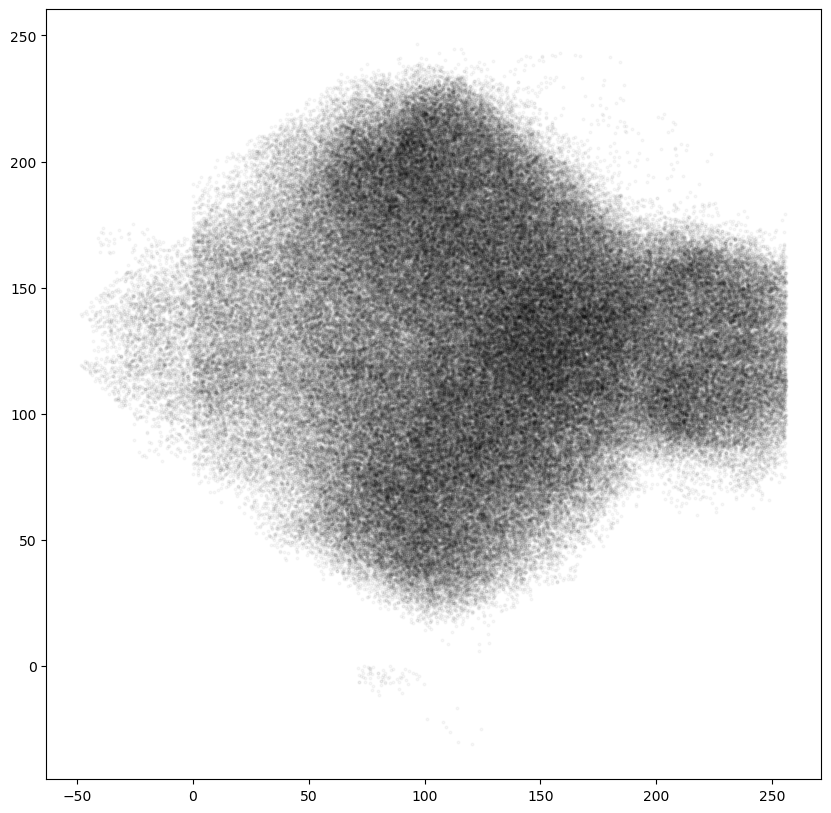

8990


In [155]:
#Plot all registered cells
fig,axarr = plt.subplots(figsize = (10,10))
comb_coords = np.load(reglist[0])
for i in range(len(reglist)-1):
    comb_coords = np.row_stack((comb_coords,np.load(reglist[i+1])))

spatial_conversion = [.5, .5, 15]
space_coord = np.multiply(comb_coords, spatial_conversion)
axarr.scatter(space_coord[:,0], space_coord[:,1], s = 4, color = 'black' , alpha = 0.03)
plt.show()
#How many cell clusters - mean of all cells used in av calculation
sumd = 0
for i in range(len(coordlist)):
    sumd = sumd + np.load(coordlist[i]).shape[0]
n_clust = np.int(sumd/len(coordlist))
print(str(n_clust))

In [87]:
#Remove unwanted coords for plotting
x,y = 140, 240 
coordvec = []
for i in range(5):
    x  = x+10
    y = y-10
    xcoord = np.where(space_coord[:,0] > x)[0]
    ycoord = np.where((space_coord[:,1] > y))[0]
    coordvec = np.append(coordvec, np.intersect1d(xcoord,ycoord))
    
remaining = np.where(space_coord[:,1]< 5)
coordvec = np.append(coordvec, remaining)
coordvec = np.unique(coordvec.astype(int))

new_space_coord = np.zeros((space_coord.shape[0] - coordvec.shape[0], 3))
count=0
for i in range(space_coord.shape[0]):
    if i in coordvec:
        continue
    else:
        new_space_coord[count] = space_coord[i]
        count+=1


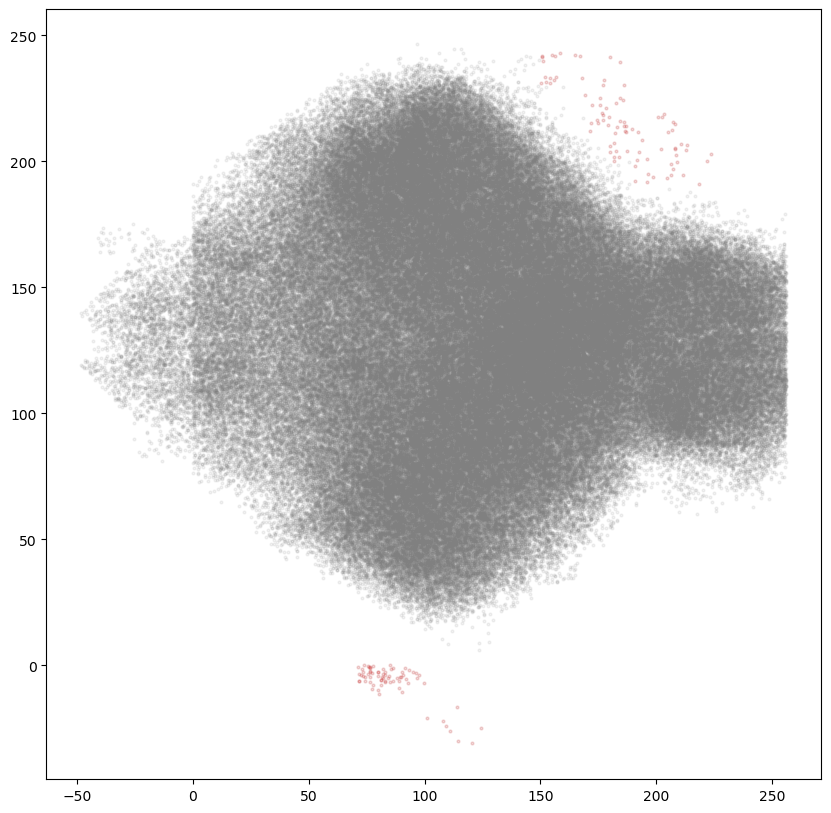

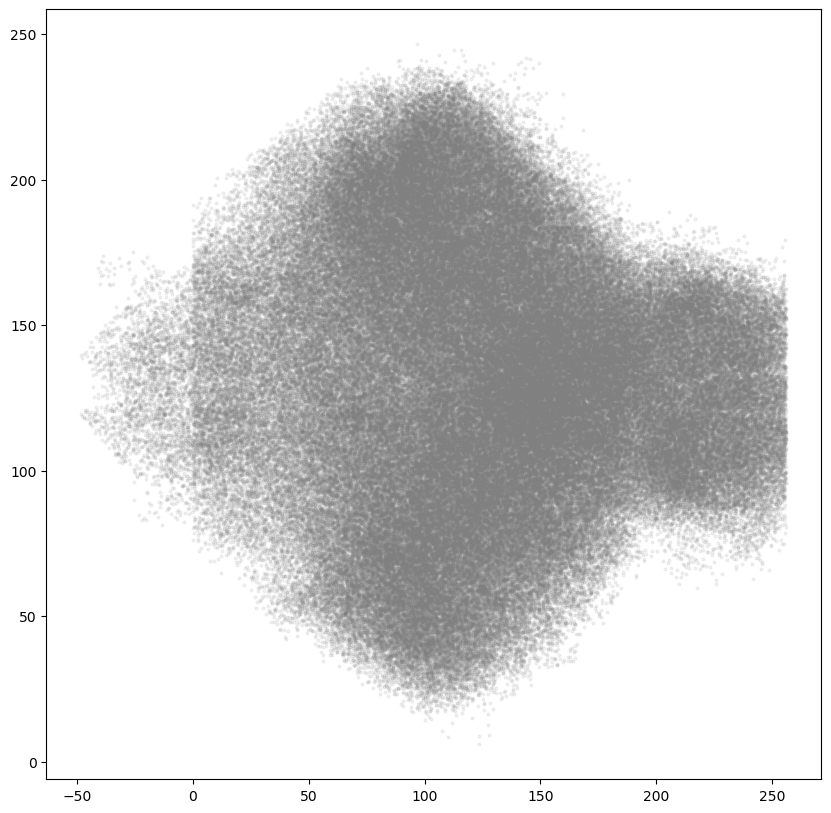

8990


In [88]:
#PLot outlier removal
fig,axarr = plt.subplots(figsize = (10,10))
axarr.scatter(space_coord[:,0], space_coord[:,1], s = 4, color = 'grey' , alpha = 0.1)
axarr.scatter(space_coord[:,0][coordvec], space_coord[:,1][coordvec], s = 4, color = 'red' , alpha = 0.1)
plt.show()

fig,axarr = plt.subplots(figsize = (10,10))
axarr.scatter(new_space_coord[:,0], new_space_coord[:,1], s = 4, color = 'grey' , alpha = 0.1)
plt.show()

sumd = 0
for i in range(len(coordlist)):
    sumd = sumd + np.load(coordlist[i]).shape[0]
n_clust = np.int(sumd/len(coordlist))
print(str(n_clust))

In [ ]:
#Kmeans clustering
from sklearn.cluster import KMeans
kmeans   = KMeans(n_clusters=n_clust, random_state=0).fit(new_space_coord)  #perform k means on all cells
klab =  kmeans.labels_
space_coord_labels = np.column_stack((new_space_coord, klab))
np.save(savepath + 'klabels-spaced-coords.npy', space_coord_labels)

In [94]:
#Average cells by labels to make new cluster
coords = np.load(net[0])
unq = np.unique(coords[:,3]).astype(int)
node_coord = np.zeros((unq.shape[0], 3))
for i in unq:
    data = coords[np.where(coords[:,3] == unq[i])][:,:3]
    node_coord[i] = [sum(x)/len(x) for x in zip(*data)]
np.save(savepath + 'knodes-coords.npy', node_coord)

In [ ]:
fig,axarr = plt.subplots(figsize = (10,10))
coords = np.load(net[0])
axarr.scatter(coords[:,0], coords[:,1], s = 4, color = 'grey' , alpha = 0.05)
axarr.scatter(node_coord[:,0], node_coord[:,1], s = 4, color = 'red' , alpha = 0.3)
plt.show()

# Connect network

## Parameters
* k = edge density, number of nearest neighbours to connect to
* p = probability of reassigning network - p defines small worldness
* s = edge weight (probability of firing), scaled for distance
* c = cycle density, dependent on k and p


## Toy models

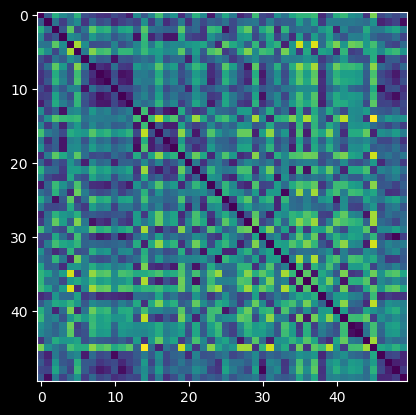

In [58]:
#Toy models
Nnodes    = 50
cell_locs = np.random.rand(Nnodes, 2)
dist = euclidean_distances(cell_locs)
plt.imshow(dist)
plt.show()

In [82]:
#Toy models
sim_list = list(range(10))
cyc_list = list(range(10))

p = 0.99
k = 2/dist.shape[0]
for i in range(10):
    sim = netfn.netsim(dist).ws_generate(k, p)
    sim_list[i] = sim.A
    
    G = nx.from_numpy_matrix(sim.A)
    cyc = nx.algorithms.cycle_basis(G)
    edge =  G.number_of_edges() 
    cyc_vec = np.zeros(len(cyc))
    for t in range(len(cyc)):
        cyc_vec[t] = len(cyc[t])
    cyc_un = np.unique(cyc_vec, return_counts=True)
    multi = np.multiply(cyc_un[0],cyc_un[1])
    cyc_list[i] = [np.sum(multi) , np.sum(multi)/len(cyc), len(cyc),edge]

In [119]:
cyc_list

[[150.0, 6.818181818181818, 22, 66],
 [174.0, 6.96, 25, 66],
 [222.0, 11.68421052631579, 19, 66],
 [202.0, 10.1, 20, 66],
 [139.0, 6.043478260869565, 23, 66],
 [167.0, 7.9523809523809526, 21, 66],
 [145.0, 7.25, 20, 66],
 [177.0, 7.695652173913044, 23, 66],
 [118.0, 5.619047619047619, 21, 66],
 [132.0, 6.285714285714286, 21, 66]]

## Parameter sweep
* Find optimal range of k,p,s that matches empirical data
* what combination maximises cycle variance
* network sizes - how does that affect cycle variance

In [395]:
# Find empirical avalanches - find appropriate range
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)

blnlist = sorted(glob.glob('*BLN*_av.npy*'))
p5list = sorted(glob.glob('*PTZ05*_av.npy*'))
p20list = sorted(glob.glob('*PTZ20*_av.npy*'))
blnlist

['PTZ-WILDTYPE-02_2photon_sess-01-6dpf_BLN_run-01_av.npy',
 'PTZ-WILDTYPE-03_2photon_sess-01-6dpf_BLN_run-01_av.npy',
 'PTZ-WILDTYPE-04_2photon_sess-01-6dpf_BLN_run-01_av.npy',
 'PTZ-WILDTYPE-05_2photon_sess-01-6dpf_BLN_run-01_av.npy',
 'PTZ-WILDTYPE-06_2photon_sess-01-6dpf_BLN_run-01_av.npy',
 'PTZ-WILDTYPE-07_2photon_sess-01-6dpf_BLN_run-01_av.npy',
 'PTZ-WILDTYPE-08_2photon_sess-01-6dpf_BLN_run-01_av.npy',
 'PTZ-WILDTYPE-09_2photon_sess-01-6dpf_BLN_run-01_av.npy',
 'PTZ-WILDTYPE-10_2photon_sess-01-6dpf_BLN_run-01_av.npy',
 'PTZ-WILDTYPE-11_2photon_sess-01-6dpf_BLN_run-01_av.npy',
 'PTZ-WILDTYPE-12_2photon_sess-01-6dpf_BLN_run-09_av.npy']

In [142]:
bln, p5, p20 = [],[],[]
for i in range(len(blnlist)):
    bln = np.append(bln, np.max(np.load(blnlist[i])[1]))
    p5 = np.append(p5, np.max(np.load(p5list[i])[1]))
    p20 = np.append(p20, np.max(np.load(p20list[i])[1]))

In [143]:
bln, p5, p20

(array([ 198., 2455.,  107.,   46.,   12.,   27.,   41.,   11.,   36.,
          16.,   57.]),
 array([  85., 1385.,   54.,   86.,  140.,   26.,   72.,   17.,   88.,
          22.,  401.]),
 array([ 375.,  614.,  758.,  331.,  168.,  916.,  385., 1824., 3386.,
         192., 4913.]))

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy

# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
node = sorted(glob.glob('knodes*'))
netlist1 = sorted(glob.glob('*network-k-0.001*-cycles*'))
netlist2 = sorted(glob.glob('*network-k-0.05*-cycles*'))
netlist3 = sorted(glob.glob('*network2*k-0.001*-cycles*'))
netlist4 = sorted(glob.glob('*network2*k-0.05*-cycles*'))

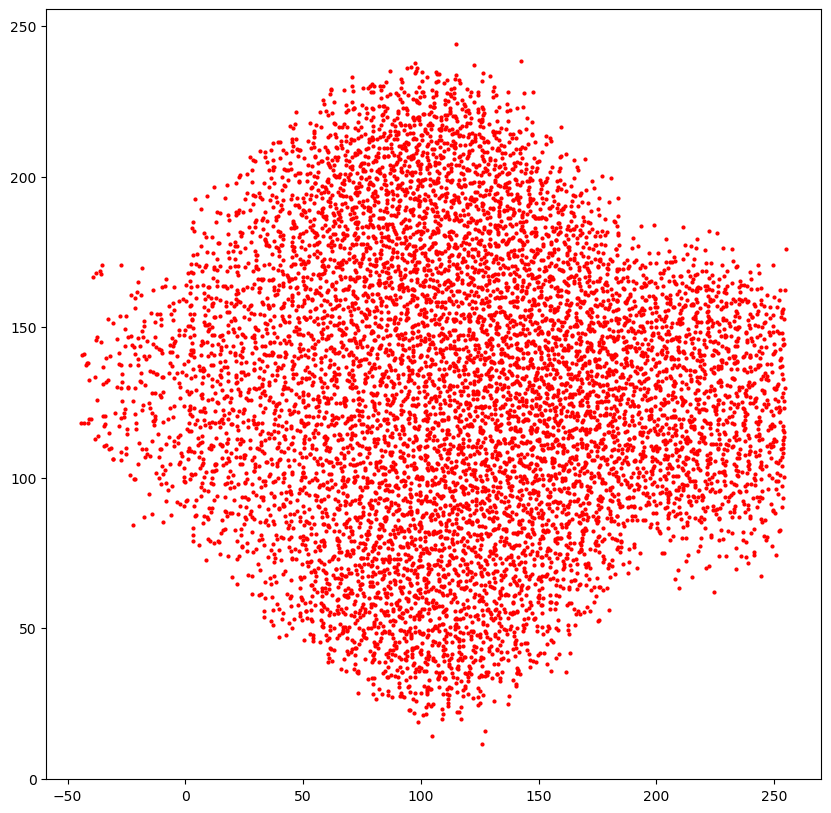

In [7]:
fig,axarr = plt.subplots(figsize = (10,10))
nodes = np.load(node[0])
axarr.scatter(nodes[:,0], nodes[:,1], s = 4, color = 'red' , alpha = 1)
plt.show()

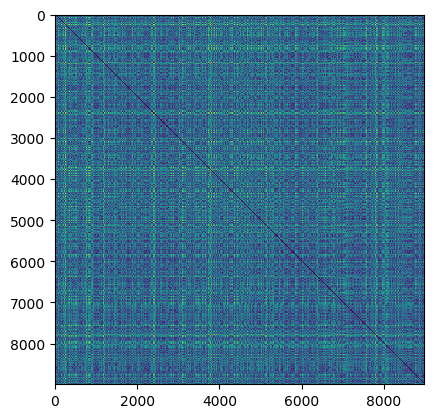

In [8]:
#K + P - LOG SCALE 
import numpy as np
import matplotlib.pyplot as plt
p_vals = adfn.repeat_list(0.1,10)
k_vals = []
for i in range(10):
    k_vals = np.append(k_vals, (i+1)/nodes.shape[0])

cell_locs = nodes
dist = euclidean_distances(nodes)
plt.imshow(dist)
plt.show()

In [277]:
#=====================
#=====================
class netsim: 
#=====================
#=====================
    """
    Class to perform network simulations
    """

    #========================
    def __init__(self,dist):
    #========================
        import numpy as np
        self.A = np.zeros(dist.shape)
        self.dist = dist
    
    #====================================
    def k_neighbours(self,edge_density):
    #====================================
        import numpy as np
        """
        Form connections with k-nearest neighbours
        """
        
        # Loop through rows of distance matrix to find k_neighbours
        #-----------------------------------------------------------------------------
        for row in range(self.dist.shape[0]):
            k_neighbours = int(self.A.shape[0] * edge_density) #Find k_neighbours for each cell
            #down = int(k_neighbours)
            #up= int(k_neighbours)+1
            #if np.random.uniform(down, up) >= k_neighbours:
            #    k_neighbours = down
            #else:
            #    k_neighbours = up
            neighbours = self.dist[row,].argsort()[:k_neighbours+1][::-1] #find neighbours 
            self.A[row,neighbours[:-1]] = 1 #make all edges of neighbours connected in network
            self.A[neighbours[:-1],row] = 1
        return self
    
    #=====================================
    def ws_generate(self, edge_density, p):
    #=====================================
        """
        Generate random small world graph with specific Edge density. The Watts-Strogatz model has (i) a small average shortest path length, and (ii) a large clustering coefficient. The algorithm works by assigning a pre-defined number of connections between k-nearest neighbours - it then loops through each node and according to some uniform probability re-assigns its edges from its connected k-nearest neighbours and a random unconnected node. 

            edge_density = number of k_nearest neighbours each node is connected to
            p = probability of an edge being randomly re-assigned
            Nnodes = number of nodes
            dist = distance matrix between all nodes in network
        """
        import numpy as np
        import networkx as nx
        import random
        import copy
        
        self.k_neighbours(edge_density)

        # Rewire connections with certain probability
        #-----------------------------------------------------------------------------
        [rows, cols]    = np.where(np.triu(self.A) == 1) 
        probs           = np.random.uniform(size = rows.shape[0]) #Generate random values for each connection 
        edges_to_change = np.where(probs <= p)[0] #see which values are randomly changed
        self.old_A  = copy.deepcopy(self.A) #create copy of A

        for e in range(edges_to_change.shape[0]): #Loop through edges to change
            this_edge = edges_to_change[e]
            self.A[rows[this_edge], cols[this_edge]] = 0         # switch off old edge
            self.A[cols[this_edge], rows[this_edge]] = 0

            where_0 = np.where(self.A[rows[this_edge]] == 0)[0] #find possible connections to reassign to
            new_edge = random.choice(where_0[np.where(where_0 !=rows[this_edge])[0]]) #randomly choose one - ignoring any connections on the diagonal 
            #Assign connection
            self.A[rows[this_edge], new_edge] = 1        # switch on new edge
            self.A[new_edge, rows[this_edge]] = 1
        return(self)


In [483]:
#=====================
#=====================
class prac_prac: 
#=====================
#=====================
    """
    Class to perform network simulations
    """

    #========================
    def __init__(self,edge):
    #========================
        import numpy as np
        self.A =  2+edge
    
    #====================================
    def porc(self,x,y):
    #====================================
        import numpy as np
        """
        Form connections with k-nearest neighbours
        """
        
        # Loop through rows of distance matrix to find k_neighbours
        #-----------------------------------------------------------------------------
        self.output1 = (4*self.A +x * y)  
        self.output2 = [(4*self.A * x * y - 300), 0,1,x,y]  
        return self

In [572]:
cores = 4 #n_cores
edge = 10
iter_list = (np.linspace(2,13,12)).tolist() #parameter you are iterating
func = prac_prac(edge).porc #function you are applying
param_list = [5] #remaining parameters that are constant
name = 'prac'
variables = ['output1', 'output2']
savepath = savepath
mode = 'save_single'
#parallel(cores, savepath, iter_list, func, param_list, name, 'save_group')

In [593]:
os.chdir(Fdrop + 'Project/' + experiment)
blnlist = sorted(glob.glob('*prac.*'))
blnlist

['prac.npy']

In [585]:
for i in range(len(blnlist)):
    print(str(blnlist[i]) + ' ' + str(np.load(blnlist[i])))

prac-02.0-output1.npy 58.0
prac-03.0-output1.npy 63.0
prac-04.0-output1.npy 68.0
prac-05.0-output1.npy 73.0
prac-06.0-output1.npy 78.0
prac-07.0-output1.npy 83.0
prac-08.0-output1.npy 88.0
prac-09.0-output1.npy 93.0
prac-10.0-output1.npy 98.0
prac-11.0-output1.npy 103.0
prac-12.0-output1.npy 108.0
prac-13.0-output1.npy 113.0


In [577]:
return_me[1]

[[180.0, 0, 1, 2.0, 5],
 [420.0, 0, 1, 3.0, 5],
 [660.0, 0, 1, 4.0, 5],
 [900.0, 0, 1, 5.0, 5],
 [1140.0, 0, 1, 6.0, 5],
 [1380.0, 0, 1, 7.0, 5],
 [1620.0, 0, 1, 8.0, 5],
 [1860.0, 0, 1, 9.0, 5],
 [2100.0, 0, 1, 10.0, 5],
 [2340.0, 0, 1, 11.0, 5],
 [2580.0, 0, 1, 12.0, 5],
 [2820.0, 0, 1, 13.0, 5]]

In [478]:
for i in range(len(iter_list)):
    save_name = name + str(i+2)
    save_val = prac_prac(edge).porc(iter_list[i], 5).output1
    print(str(save_name) + ' ' + str(save_val))

prac2 58.0
prac3 63.0
prac4 68.0
prac5 73.0
prac6 78.0
prac7 83.0
prac8 88.0
prac9 93.0
prac10 98.0
prac11 103.0
prac12 108.0
prac13 113.0


In [479]:
for i in range(len(iter_list)):
    save_name = name + str(i+2)
    save_val = prac_prac(edge).porc(iter_list[i], 5).output2
    print(str(save_name) + ' ' + str(save_val))

prac2 [180.0, 0, 1, 2.0, 5]
prac3 [420.0, 0, 1, 3.0, 5]
prac4 [660.0, 0, 1, 4.0, 5]
prac5 [900.0, 0, 1, 5.0, 5]
prac6 [1140.0, 0, 1, 6.0, 5]
prac7 [1380.0, 0, 1, 7.0, 5]
prac8 [1620.0, 0, 1, 8.0, 5]
prac9 [1860.0, 0, 1, 9.0, 5]
prac10 [2100.0, 0, 1, 10.0, 5]
prac11 [2340.0, 0, 1, 11.0, 5]
prac12 [2580.0, 0, 1, 12.0, 5]
prac13 [2820.0, 0, 1, 13.0, 5]


In [574]:
return_me

[[58.0, 63.0, 68.0, 73.0, 78.0, 83.0, 88.0, 93.0, 98.0, 103.0, 108.0, 113.0],
 [[180.0, 0, 1, 2.0, 5],
  [420.0, 0, 1, 3.0, 5],
  [660.0, 0, 1, 4.0, 5],
  [900.0, 0, 1, 5.0, 5],
  [1140.0, 0, 1, 6.0, 5],
  [1380.0, 0, 1, 7.0, 5],
  [1620.0, 0, 1, 8.0, 5],
  [1860.0, 0, 1, 9.0, 5],
  [2100.0, 0, 1, 10.0, 5],
  [2340.0, 0, 1, 11.0, 5],
  [2580.0, 0, 1, 12.0, 5],
  [2820.0, 0, 1, 13.0, 5]]]

In [591]:
cores = 4 #n_cores
edge = 10
iter_list = (np.linspace(2,13,12)).tolist() #parameter you are iterating
func = prac_prac(edge).porc #function you are applying
param_list = [5] #remaining parameters that are constant
name = 'prac'
variables = ['output1', 'output2']
savepath = savepath
mode = 'save_single'
parallel_class(cores, savepath, iter_list, func, param_list, name, variables, 'save_group')

In [590]:
#=====================================================================
def parallel_class(cores, savepath, iter_list, func, param_list, name, variables, mode): 
#=====================================================================
    """This function allows parallel pooling of processes using classes
    cores = number of cores 
    savepath = path for saving
    iter_list = list with parameter inputs that you will parallel process (inputs must be at start of function)
    func = function name
    param_list = list containing remaining function parameters 
    name = filename for saving, should be unique if mode = save_group
    variables = list containing name endings for each variable, if function returns multiple
    mode = output type:
        save_single - saves each instance of function output individually
        save_group - saves all batched function outputs in a list
        NA - returns all batched function outputs in a list, without saving
    """
    
    from multiprocessing import Pool
    import numpy as np
    pool = Pool(cores) #number of cores
    count = 0

    batch_list = list(range((np.int(len(iter_list)/cores)))) #define number of batches
    for i in range(len(batch_list)): #process each batch
        cores_inputs = list(range(cores)) #define input for each core
        for e in range(len(cores_inputs)):  
            sub_iter_list = iter_list[count:count+1] #Find current iter value - add to subset iter_list
            sub_iter_list.extend(param_list) #Append current iter value onto remaining parameter
            cores_inputs[e] = sub_iter_list 
            count+=1
        batch_list[i] = pool.starmap(func, cores_inputs) #pool process on each core

        if mode == 'save_single':
            for t in range(cores):  #loop through each core in current loop
                for s in range(len(variables)):
                    save_var = batch_list[i][t].__dict__[variables[s]] #function output for current core in current batch
                    save_name = name + '-' + str(cores_inputs[t][0]) + '-' + variables[s] #save name based on iterable parameter
                    np.save(savepath + save_name, save_var)

    if mode != 'save_single':
    
        #Append all calculated values together
        if len(variables) == 1:
            if isinstance(batch_list[0][0].__dict__[variables[0]], int) or isinstance(batch_list[0][0].__dict__[variables[0]], float):
                count=0
                return_me = list(range(len(iter_list)))
                for first in range(len(batch_list)):
                    for second in range(len(batch_list[0])):
                        return_me[count] = batch_list[first][second].__dict__[variables[0]]
                        count+=1

        if len(variables) > 1:
            count=0
            return_me = adfn.list_of_list(len(variables),len(iter_list))
            for first in range(len(batch_list)):
                for second in range(len(batch_list[0])):
                    for third in range(len(variables)):
                        return_me[third][count] = batch_list[first][second].__dict__[variables[third]]
                    count+=1
        
        if mode == 'save_group':
            save_name = name
            np.save(savepath + save_name, return_me)
        
        else:
            return(return_me)

In [ ]:
paramlist = [k_vals[0]]
output = adfn.parallel(2, p_vals[:2], netfn.watt, paramlist, netfn.netsim)
cores = 2
listlist = p_vals[:2]
func = netsim(dist).ws_generate
paramlist = [k_vals[0]]

In [ ]:
savepath = Fdrop + 'Project/' + experiment + os.sep 

#k and p
#===================================
from scipy import sparse
import scipy
import networkx as nx
for i in range(len(k_vals)):
    for e in range(len(p_vals)):
        output = netfn.netsim(dist).ws_generate(k_vals[i], p_vals[e])
        sparse_A = sparse.csr_matrix(output.A)
        scipy.sparse.save_npz(savepath + 'network-k' + str(k_vals[i]) + '-p' + str(p_vals[e]) + '-' + str(e+1), sparse_A)
        mat = output.A
        G = nx.from_numpy_matrix(mat)
        cyc = nx.algorithms.cycle_basis(G)
        edge =  G.number_of_edges() 
        cyc_vec = np.zeros(len(cyc))
        for t in range(len(cyc)):
            cyc_vec[t] = len(cyc[t])
        cyc_list = [np.unique(cyc_vec, return_counts=True),len(cyc),edge]
        np.save(savepath + 'network-k-' +  str(k_vals[i]) + '-p' + str(p_vals[e]) + '-' + str(e+1) + '-cycles.npy', cyc_list)

In [ ]:
#What maximises cycle variance
#==============================

In [ ]:
# Calculate cycle parameters
for i in range(len(netlist3)):
    vals = np.load(netlist3[i], allow_pickle=True)
    cycles = vals[1]
    edges = vals[2]
    cyc_dens = cycles/edges
    multi = np.multiply(vals[0][0],vals[0][1])
    cyc_nodes =  np.sum(multi)
    mean_cyc_nodes = (cyc_nodes/cycles)
    print(cycles, edges, cyc_dens, cyc_nodes, mean_cyc_nodes)

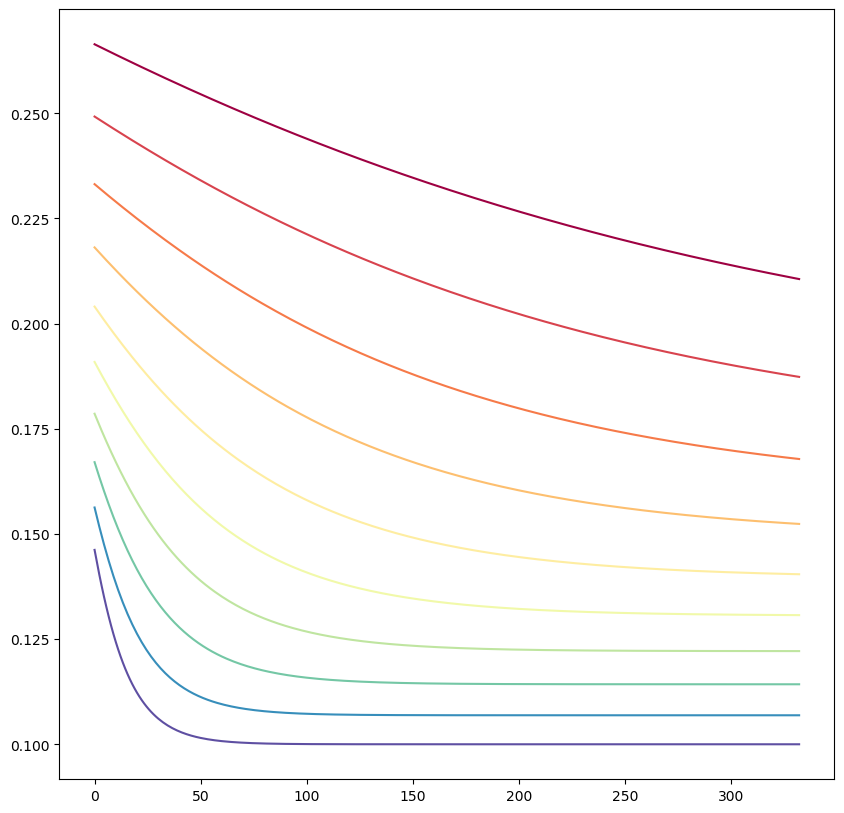

In [157]:
#S
#===================================

# Find maximum distance between nodes
cell_locs = nodes
dist = euclidean_distances(cell_locs)
np.max(dist), np.min(dist)

# Simple sigmoid function to 'soften' the exponential
#-------------------------------------------------------------------------------
def sig(x):
  return 1 / (1+np.exp(-x))

# Conversion from distance to edge weights, scaled (itself exponentially) by s
#low k - divisor = 5
#high k - divisor = 10
#really high divisor = 400
#-------------------------------------------------------------------------------
divisor = 5
def dist2edge(distance, s):
  edgeweights = np.exp(s/5)*sig(np.exp(-0.07/np.exp(s)*distance))/divisor
  return edgeweights

# Calculate and plot in a loop with s increasing from 0 to 2
#===============================================================================
Nsteps  = 10
svals   = np.linspace(0, 3, Nsteps)
#svals   = np.linspace(0, 3, Nsteps)
fig, ax = plt.subplots(1, figsize=(10,10))
colors  = cm.Spectral_r(np.linspace(0,1,Nsteps))

distance = np.linspace(0, np.max(dist), 300)
for s in range(len(svals)):
  ax.plot(distance, dist2edge(distance, svals[s]), c=colors[s])
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()

In [ ]:
#Sweep through s range
from scipy import sparse
Nsteps  = 10
svals   = np.linspace(0, 2.3, Nsteps)

for i in range(len(netlist)):
    mat = scipy.sparse.load_npz(netlist[i])
    mat = mat.todense()
    adj_mat = np.zeros((dist.shape))
    [rows, cols]    = np.where(np.triu(mat) == 1) 
    
    for s in range(len(svals)):
        for e in range(len(rows)):
            edge_weight = dist2edge(dist[rows[e], cols[e]],svals[s])
            adj_mat[rows[e], cols[e]] = edge_weight 
            adj_mat[cols[e], rows[e]] = edge_weight
        sparse_adj_mat = sparse.csr_matrix(adj_mat) 
        scipy.sparse.save_npz(savepath + 'lowk-adjmat' + netlist[0][netlist[0].find('-k'):netlist[0].find('.npz')-2:] + '-s' + str(svals[s]), sparse_adj_mat)
        print('Done ' + str(netlist[i]))

# Simulate avalanches


In [135]:
# Find networks
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
choose = 4
adjlist = sorted(glob.glob('*lowk*' + str(k_vals[2]) + '*p0.5-1*'))
cycle_list = sorted(glob.glob('network2*k-0.05*cycles*'))
adjlist

['lowk-adjmat-k0.0003337041156840934-p0.5-1.npz',
 'lowk-network-k-0.0003337041156840934-p0.5-1-cycles.npy',
 'lowk-network-k-0.0003337041156840934-p0.5-10-cycles.npy',
 'lowk-network-k0.0003337041156840934-p0.5-1.npz',
 'lowk-network-k0.0003337041156840934-p0.5-10.npz']

In [ ]:
#ORDER ACCORDING TO CYCLE NUMBER
#P=0.9
cycles = sorted(glob.glob('network2*k-0.001*cycles*'))
cyclist=[]
for i in range(len(cycles)):
    cyclist = np.append(cyclist, np.load(cycles[i], allow_pickle=True)[1])
sort_netlist = [x for _,x in sorted(zip(cyclist, adjlist))]
adjlist = sort_netlist
adjlist

In [765]:
# ORDER ACCORDING TO CYCLE LENGTH
cyclist = []
for i in range(len(cycle_list)):
    vals = np.load(cycle_list[i], allow_pickle=True)
    cycles = vals[1]
    edges = vals[2]
    cyc_dens = cycles/edges
    multi = np.multiply(vals[0][0],vals[0][1])
    cyc_nodes =  np.sum(multi)
    mean_cyc_nodes = (cyc_nodes/cycles)
    cyclist =  np.append(cyclist, cyc_nodes)
sort_netlist = [x for _,x in sorted(zip(cyclist, adjlist))]
adjlist = sort_netlist
adjlist

['highk-adjmat-k0.05-p0.1-3.npz',
 'highk-adjmat-k0.05-p0.1-5.npz',
 'highk-adjmat-k0.05-p0.1-1.npz',
 'highk-adjmat-k0.05-p0.1-2.npz',
 'highk-adjmat-k0.05-p0.1-4.npz']

In [770]:
#Ping random node
n_sims = 1000

av_size_list, av_dur_list = list(range(len(adjlist))), list(range(len(adjlist)))
for o in range(len(adjlist)):
    mat = scipy.sparse.load_npz(adjlist[o])
    mat = mat.todense()
    mat = np.asarray(mat)

    av_size = []
    av_dur = []

    for i in range(n_sims):

        #Decide start node
        start_node = np.random.uniform(0, mat.shape[0]-1)
        down = int(start_node)
        up= int(start_node)+1
        if np.random.uniform(down, up) >= start_node:
            start_node = up
        else:
            start_node = down

        #Find cells to propagate
        def propagate_neighbours(mat, start_node):
            prop_nodes = []
            nodes = np.where(mat[start_node] > 0) [0]
            weights = mat[start_node][nodes]
            for f in range(len(nodes)):
                if weights[f] > np.random.uniform(0, 1):
                    prop_nodes = np.append(prop_nodes, nodes[f])
            return(prop_nodes)


        #Initialise avalanche - ping first node
        t_nodes = propagate_neighbours(mat, start_node) #Find connected neighbours > threshold
        curr_list = t_nodes
        iterate = 'yes'

        if len(t_nodes) > 1: #must have at least 3 cells to begin avalanche
            all_nodes = np.append(start_node, t_nodes)
            timesteps = 1

            while iterate == 'yes':
                tplus_nodes = []
                for z in range(len(curr_list)):
                    #List of all nodes active in next timestep
                    tplus_nodes = np.append(tplus_nodes, propagate_neighbours(mat, int(curr_list[z])))

                all_nodes = np.append(all_nodes, tplus_nodes)
                timesteps+=1
                curr_list = tplus_nodes

                if len(tplus_nodes) == 0: #if no more active cells - stop
                    iterate = 'no'
            av_size = np.append(av_size, len(all_nodes)) 
            av_dur = np.append(av_dur, timesteps)

        else:
            continue
            
    av_size_list[o] = av_size
    av_dur_list[o] = av_dur
    print('Done network ' + str(o+1))

Done network 1
Done network 2
Done network 3
Done network 4
Done network 5


# Fit optimal parameter combination
1. For each edge decile-cycle decile combination - concatenate all avalanche simulations into 1 distribution
2. Plot as pdf
3. Empirical distribution - concatenate together, or use fish that minimises ks distance to mean distribution
4. Which parameters minimise ks distance to empirical baseline + ptz data
5. Compare parameters

# Effect of individual parameters
1. Bayesian approach - which singular parameter change best explains shift during seizures

### Cycles

/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collectio

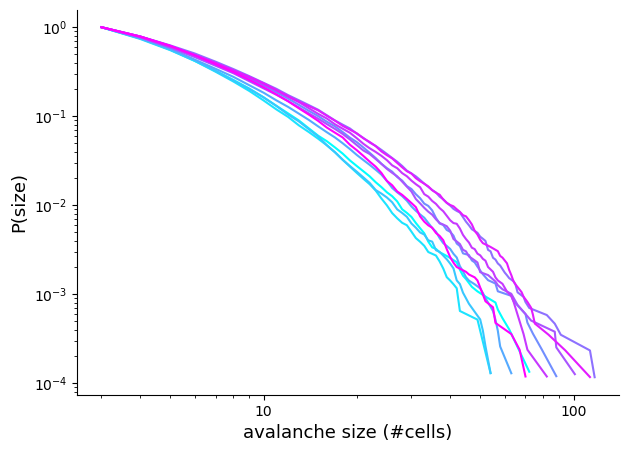

In [118]:
#Cycle length - small network
import matplotlib
import powerlaw
colors = cm.cool(np.linspace(0, 1, len(av_size_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_size_list)):
    av = np.append(av, av_size_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_size_list)):
    binned=np.linspace(mini,maxi, 100)
    hist = np.histogram(av_size_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_size_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collectio

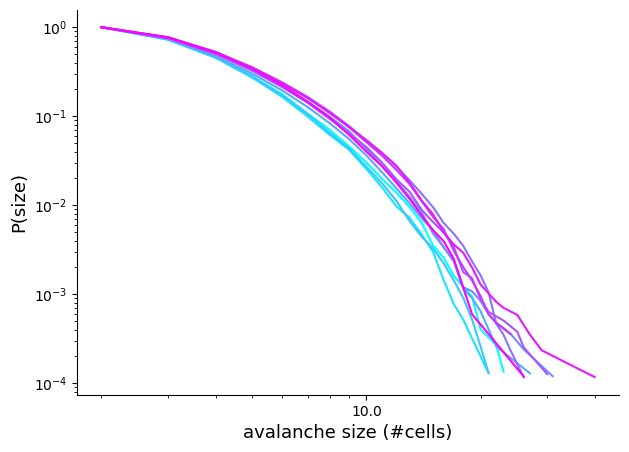

In [117]:
#Cycle number
import matplotlib
colors = cm.cool(np.linspace(0, 1, len(av_dur_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_dur_list)):
    av = np.append(av, av_dur_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_dur_list)):
    binned=np.linspace(mini,maxi, 10)
    hist = np.histogram(av_dur_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_dur_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collectio

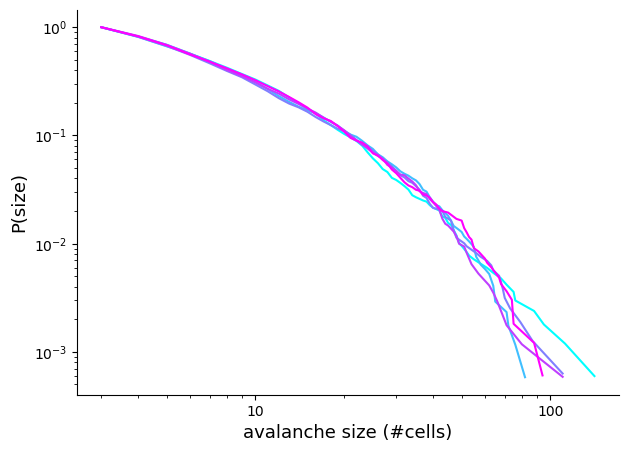

In [771]:
#Cycle length - high k
import matplotlib
import powerlaw
colors = cm.cool(np.linspace(0, 1, len(av_size_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_size_list)):
    av = np.append(av, av_size_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_size_list)):
    binned=np.linspace(mini,maxi, 100)
    hist = np.histogram(av_size_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_size_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collectio

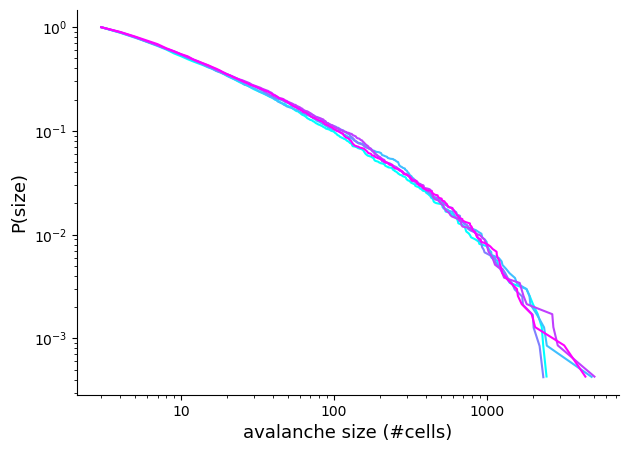

In [724]:
#Cycle length - high k
import matplotlib
import powerlaw
colors = cm.cool(np.linspace(0, 1, len(av_size_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_size_list)):
    av = np.append(av, av_size_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_size_list)):
    binned=np.linspace(mini,maxi, 100)
    hist = np.histogram(av_size_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_size_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collectio

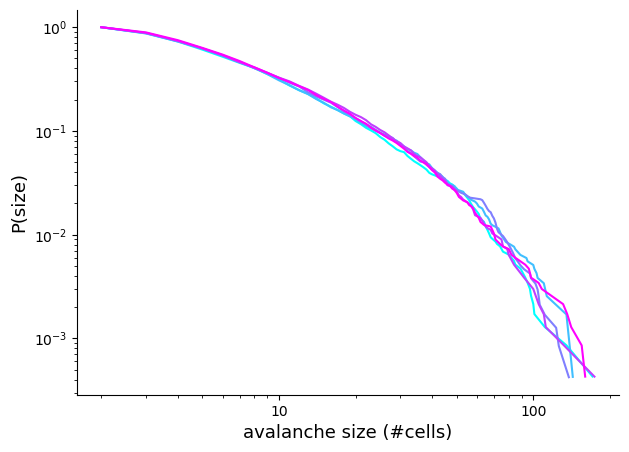

In [725]:
#Cycle length number
import matplotlib
colors = cm.cool(np.linspace(0, 1, len(av_dur_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_dur_list)):
    av = np.append(av, av_dur_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_dur_list)):
    binned=np.linspace(mini,maxi, 10)
    hist = np.histogram(av_dur_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_dur_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collectio

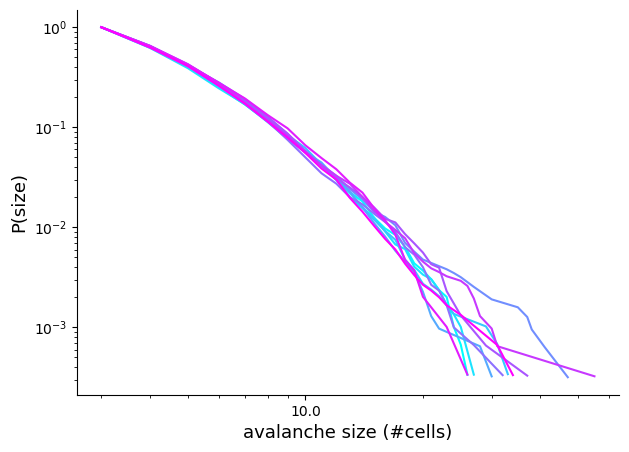

In [550]:
#Cycle number - 0 edges
import matplotlib
import powerlaw
colors = cm.cool(np.linspace(0, 1, len(av_size_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_size_list)):
    av = np.append(av, av_size_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_size_list)):
    binned=np.linspace(mini,maxi, 10)
    hist = np.histogram(av_size_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_size_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collectio

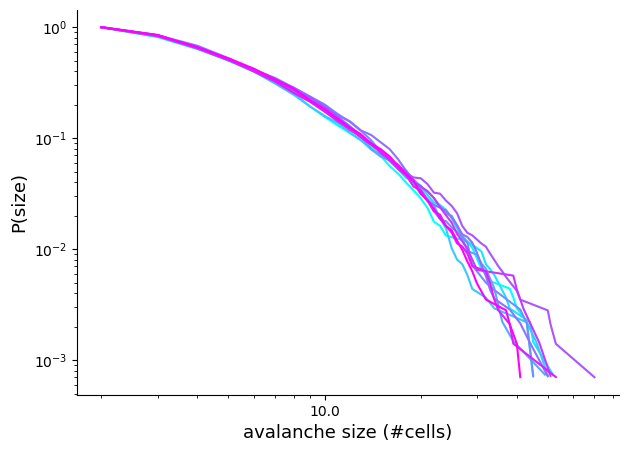

In [486]:
#Cycle number
import matplotlib
colors = cm.cool(np.linspace(0, 1, len(av_dur_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_dur_list)):
    av = np.append(av, av_dur_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_dur_list)):
    binned=np.linspace(mini,maxi, 10)
    hist = np.histogram(av_dur_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_dur_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

### K

/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collectio

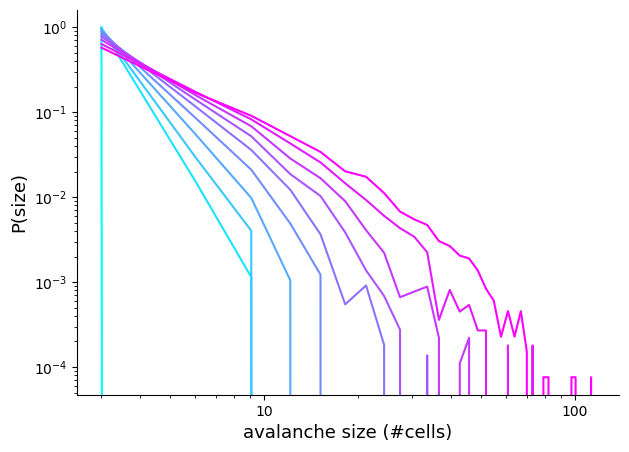

In [314]:
import matplotlib
colors = cm.cool(np.linspace(0, 1, len(av_size_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_size_list)):
    av = np.append(av, av_size_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_size_list)):
    binned=np.linspace(mini,maxi, 40)
    hist = np.histogram(av_size_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collectio

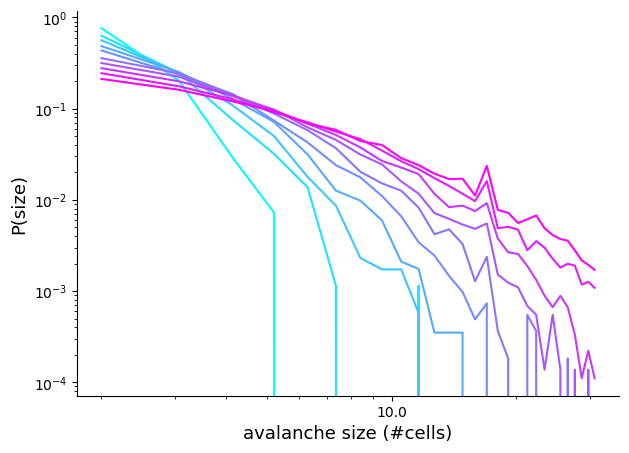

In [321]:
import matplotlib
colors = cm.cool(np.linspace(0, 1, len(av_dur_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_dur_list)):
    av = np.append(av, av_dur_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_dur_list)):
    binned=np.linspace(mini,maxi, 30)
    hist = np.histogram(av_size_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

### P

/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collectio

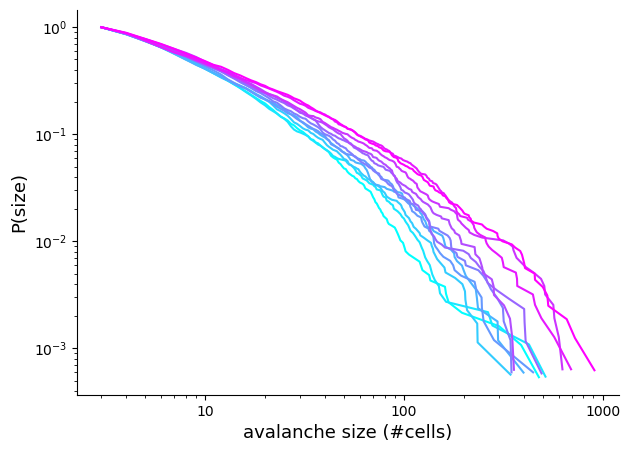

In [586]:
import matplotlib
colors = cm.cool(np.linspace(0, 1, len(av_size_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_size_list)):
    av = np.append(av, av_size_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_size_list)):
    binned=np.linspace(mini,maxi, 40)
    hist = np.histogram(av_size_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_size_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collectio

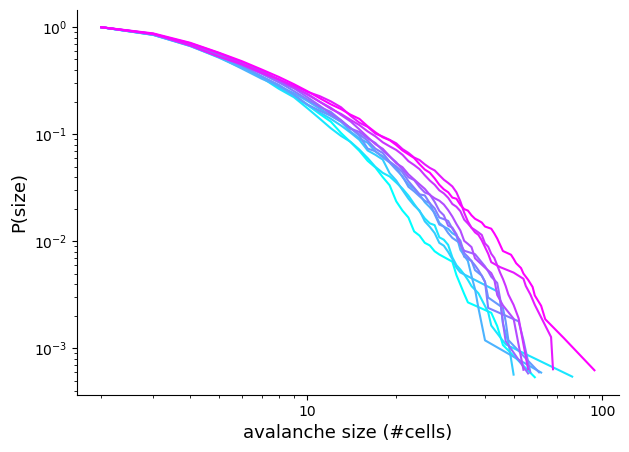

In [587]:
import matplotlib
colors = cm.cool(np.linspace(0, 1, len(av_dur_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_dur_list)):
    av = np.append(av, av_dur_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_dur_list)):
    binned=np.linspace(mini,maxi, 40)
    hist = np.histogram(av_dur_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_dur_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

### S

/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collectio

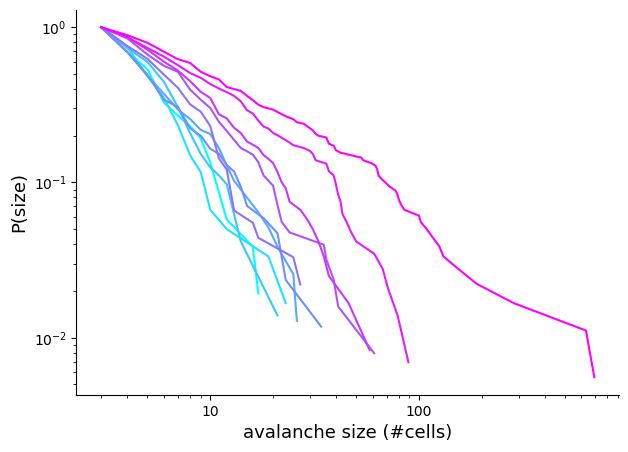

In [611]:
import matplotlib
colors = cm.cool(np.linspace(0, 1, len(av_size_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_size_list)):
    av = np.append(av, av_size_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_size_list)):
    binned=np.linspace(mini,maxi, 40)
    hist = np.histogram(av_size_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_size_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/dominicburrows/anaconda3/lib/python3.7/_collectio

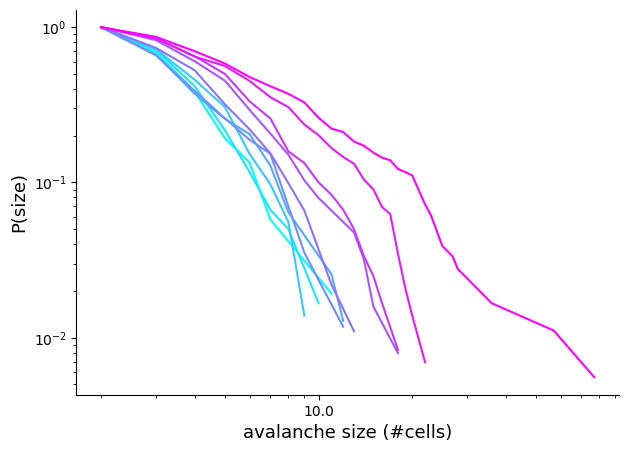

In [612]:
import matplotlib
colors = cm.cool(np.linspace(0, 1, len(av_dur_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_dur_list)):
    av = np.append(av, av_dur_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_dur_list)):
    binned=np.linspace(mini,maxi, 40)
    hist = np.histogram(av_dur_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_dur_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

# Old parameter sweep

In [7]:
#K + P - LOG SCALE 
import numpy as np
import matplotlib.pyplot as plt
p_vals = np.geomspace(0.001, 1, 50)
p_vals = [round(p_vals[i],4) for i in range(p_vals.shape[0])]
k_vals = np.geomspace((1/nodes.shape[0]), 0.5, 50)
k_vals = [round(k_vals[i], 6) for i in range(k_vals.shape[0])]

cell_locs = nodes
dist = euclidean_distances(nodes)


newp_vals = []
for i in range(len(cyclist)):
    newp_vals = np.append(newp_vals,cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-cy')])

In [ ]:
savepath = F10t + 'Project/' + experiment + os.sep 

# Sweep through k and p
#----------------------------------------
from scipy import sparse
import scipy
import networkx as nx
for i in range(len(k_vals)):
    for e in range(len(p_vals)):
        output = netfn.netsim(dist).ws_generate(k_vals[i], p_vals[e])       
        sparse_A = sparse.csr_matrix(output.A)   
    
        scipy.sparse.save_npz(savepath + 'psweep2-netparam-k' + str(k_vals[i]) + '-p' + str(p_vals[e]), sparse_A)
    adfn.timeprint(10, i, len(k_vals), str(k_vals[i]))

In [ ]:
# Calculate cycles
#----------------------------------------
from scipy import sparse
import scipy
import networkx as nx
for i in range(len(p_vals)):
    p_list = sorted(glob.glob('psweep2*p*' + str(p_vals[i]) + '*'))
    cyc_list = adfn.list_of_list(len(p_list),3)
    for e in range(len(p_list)):
        mat = scipy.sparse.load_npz(p_list[e])
        mat = mat.todense()
        G = nx.from_numpy_matrix(mat)
        cyc = nx.algorithms.cycle_basis(G)
        edge =  G.number_of_edges() 
        cyc_vec = np.zeros(len(cyc))
        for t in range(len(cyc)):
            cyc_vec[t] = len(cyc[t])
        cyc_list[e] = [np.unique(cyc_vec, return_counts=True),len(cyc),edge]
    np.save(savepath + 'netparam2-' + p_list[0][p_list[0].find('-p')+1:p_list[0].find('.npz')] + '-cycles.npy', cyc_list)
    print('Done fish ' + str(p_vals[i]))

In [9]:
#Calculate cycle parameters 
cyc_n_list = list(range(len(cyclist)))
cyc_nodes_list = list(range(len(cyclist)))
mean_cyc_nodes_list = list(range(len(cyclist)))

for i in range(len(cyclist)):
    cyc_n = np.zeros(len(np.load(cyclist[i], allow_pickle=True)))
    cyc_nodes = np.zeros(len(np.load(cyclist[i], allow_pickle=True)))
    mean_cyc_nodes = np.zeros(len(np.load(cyclist[i], allow_pickle=True)))
    for e in range(len(np.load(cyclist[i], allow_pickle=True))):
        cyc_n[e] = np.load(cyclist[i], allow_pickle=True)[e][2]
        multi = np.multiply(np.load(cyclist[i], allow_pickle=True)[e][0][0],np.load(cyclist[i], allow_pickle=True)[e][0][1])
        cyc_nodes[e] =  np.sum(multi)
        mean_cyc_nodes[e] = (cyc_nodes[e]/cyc_n[e])
    cyc_n_list[i] = cyc_n
    cyc_nodes_list[i] = cyc_nodes
    mean_cyc_nodes_list[i] = mean_cyc_nodes
    

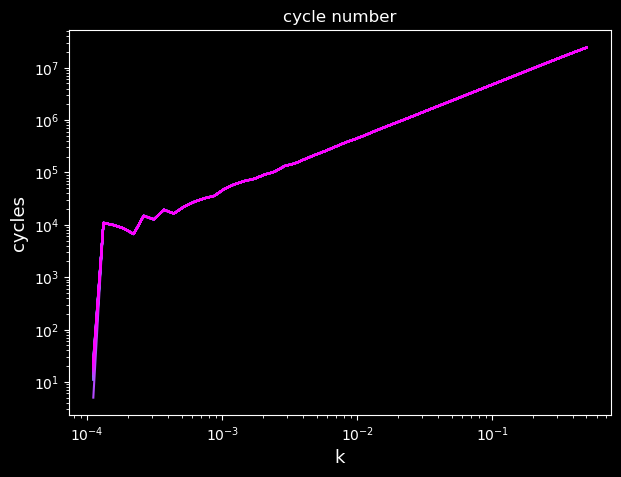

In [11]:
#As k increases how do cycles increase for all p values
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

colors = cm.cool(np.linspace(0, 1, len(cyclist)))
fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_n_list)):
    plot1 = plt.plot(k_vals, cyc_n_list[i], c = colors[i],label = cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-c')])
    axarr.set_title(str('cycle number'))
    axarr.set_ylabel('cycles', size = '13')
    axarr.set_xlabel('k', size = '13')
    axarr.set_xscale('log')
    axarr.set_yscale('log')

#axarr.legend()
plt.show()

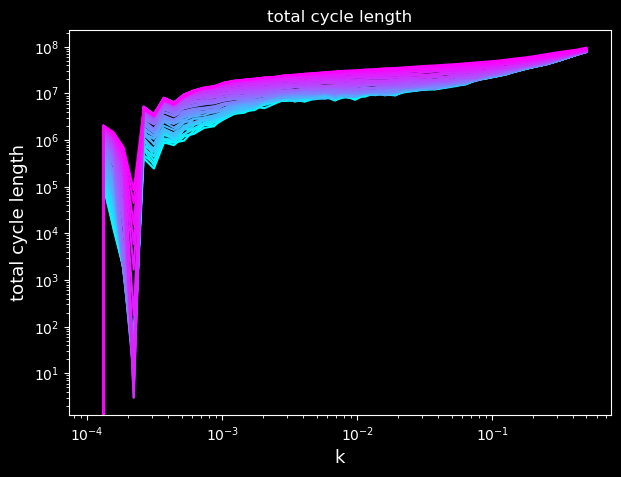

In [13]:
# as k increases how does cycle length increase for each p
colors = cm.cool(np.linspace(0, 1, len(cyclist)))
fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_nodes_list)):
    plt.plot(k_vals, cyc_nodes_list[i], c = colors[i], label = cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-c')])
    axarr.set_title(str('total cycle length'))
    axarr.set_ylabel('total cycle length', size = '13')
    axarr.set_xlabel('k', size = '13')
axarr.set_xscale('log')
axarr.set_yscale('log')
#plt.xlim(right = 0.1)  

#axarr.legend()
plt.show()

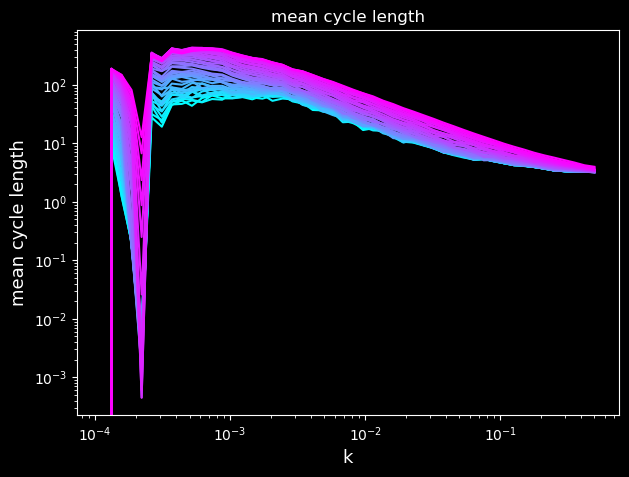

In [14]:
# as k increases how does mean cycle length change for each p

fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(mean_cyc_nodes_list)):
    plt.plot(k_vals, mean_cyc_nodes_list[i], c = colors[i], label = cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-c')])
    axarr.set_title(str('mean cycle length'))
    axarr.set_ylabel('mean cycle length', size = '13')
    axarr.set_xlabel('k', size = '13')
axarr.set_xscale('log')
axarr.set_yscale('log')
#axarr.legend()
plt.show()

In [12]:
#Calculate cycle parameters 
cyc_n_list = list(range(len(np.load(cyclist[0],allow_pickle=True))))
cyc_nodes_list = list(range(len(np.load(cyclist[0],allow_pickle=True))))
mean_cyc_nodes_list = list(range(len(np.load(cyclist[0],allow_pickle=True))))

for i in range(len(np.load(cyclist[0],allow_pickle=True))):     
    cyc_n = np.zeros(len(cyclist))
    cyc_nodes = np.zeros(len(cyclist))
    mean_cyc_nodes = np.zeros(len(cyclist))
    for e in range(len(cyclist)):
        cyc_n[e] = np.load(cyclist[e], allow_pickle=True)[i][2]
        multi = np.multiply(np.load(cyclist[e], allow_pickle=True)[i][0][0],np.load(cyclist[e], allow_pickle=True)[i][0][1])
        cyc_nodes[e] =  np.sum(multi)
        mean_cyc_nodes[e] = (cyc_nodes[e]/cyc_n[e])
    cyc_n_list[i] = cyc_n
    cyc_nodes_list[i] = cyc_nodes
    mean_cyc_nodes_list[i] = mean_cyc_nodes

In [14]:
newp_vals = []
for i in range(len(cyclist)):
    newp_vals = np.append(newp_vals,cyclist[i][cyclist[i].find('-p')+2:cyclist[i].find('-cy')])

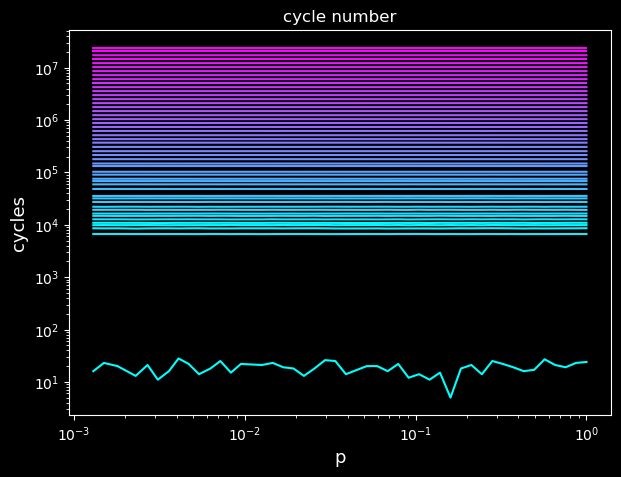

In [16]:
# as p increases how does cycles increase for each k
colors = cm.cool(np.linspace(0, 1, len(cyc_n_list)))
fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_n_list)):
    plt.plot(newp_vals.astype(float), cyc_n_list[i], c = colors[i], label = k_vals[i])
    axarr.set_title(str('cycle number'))
    axarr.set_ylabel('cycles', size = '13')
    axarr.set_xlabel('p', size = '13')
axarr.set_xscale('log')
axarr.set_yscale('log')
#axarr.legend()
plt.show()

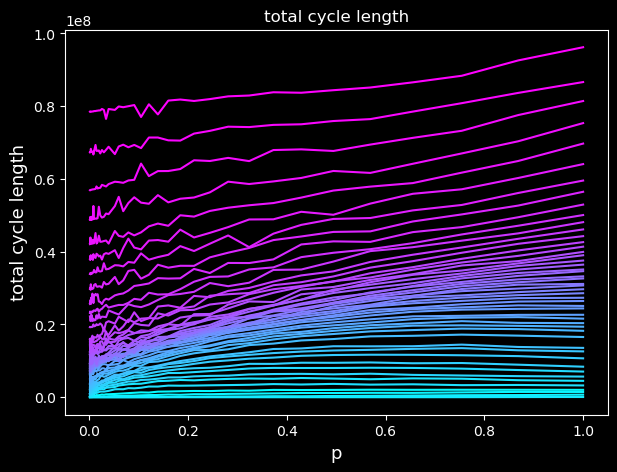

In [18]:
#as p increases how does total cycle length increase for each k

fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_nodes_list)):
    plt.plot(newp_vals.astype(float), cyc_nodes_list[i], c = colors[i], label = k_vals[i])
    axarr.set_title(str('total cycle length'))
    axarr.set_ylabel('total cycle length', size = '13')
    axarr.set_xlabel('p', size = '13')
#axarr.set_xscale('log')
#axarr.set_yscale('log')
#axarr.legend()
plt.show()

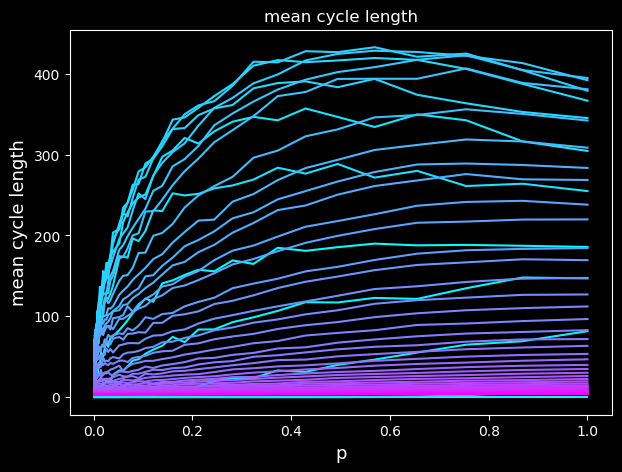

In [19]:
# as p increases how does mean cycle length increase
fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(mean_cyc_nodes_list)):
    plt.plot(newp_vals.astype(float), mean_cyc_nodes_list[i], c = colors[i], label = k_vals[i])
    axarr.set_title(str('mean cycle length'))
    axarr.set_ylabel('mean cycle length', size = '13')
    axarr.set_xlabel('p', size = '13')
#axarr.set_xscale('log')
#axarr.set_yscale('log')
#axarr.legend()
plt.show()

In [51]:
#K + P - LIN SCALE (low p)
#Calculate cycle parameters 
cyc_n_list = list(range(len(cyclist)))
cyc_nodes_list = list(range(len(cyclist)))
mean_cyc_nodes_list = list(range(len(cyclist)))

for i in range(len(cyclist)):
    cyc_n = np.zeros(len(np.load(cyclist[i], allow_pickle=True)))
    cyc_nodes = np.zeros(len(np.load(cyclist[i], allow_pickle=True)))
    mean_cyc_nodes = np.zeros(len(np.load(cyclist[i], allow_pickle=True)))
    for e in range(len(np.load(cyclist[i], allow_pickle=True))):
        cyc_n[e] = np.load(cyclist[i], allow_pickle=True)[e][2]
        multi = np.multiply(np.load(cyclist[i], allow_pickle=True)[e][0][0],np.load(cyclist[i], allow_pickle=True)[e][0][1])
        cyc_nodes[e] =  np.sum(multi)
        mean_cyc_nodes[e] = (cyc_nodes[e]/cyc_n[e])
    cyc_n_list[i] = cyc_n
    cyc_nodes_list[i] = cyc_nodes
    mean_cyc_nodes_list[i] = mean_cyc_nodes
    

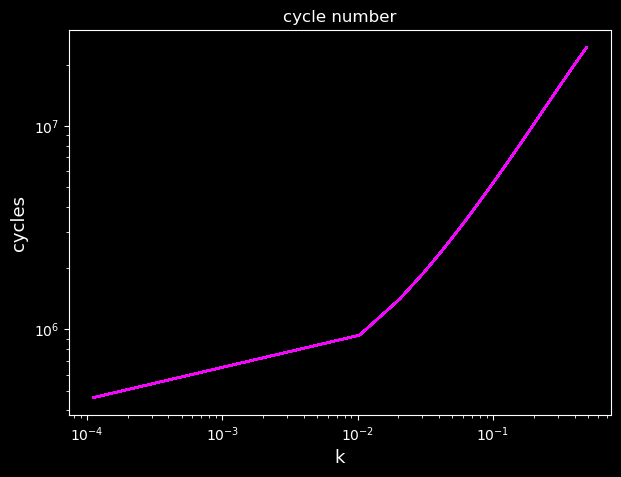

In [58]:
#As k increases how do cycles increase for all p values
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

colors = cm.cool(np.linspace(0, 1, len(cyclist)))
fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_n_list)):
    plot1 = plt.plot(k_vals[:len(k_vals)-1], cyc_n_list[i], c = colors[i],label = cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-c')])
    axarr.set_title(str('cycle number'))
    axarr.set_ylabel('cycles', size = '13')
    axarr.set_xlabel('k', size = '13')
axarr.set_xscale('log')
axarr.set_yscale('log')
#axarr.legend()
plt.show()

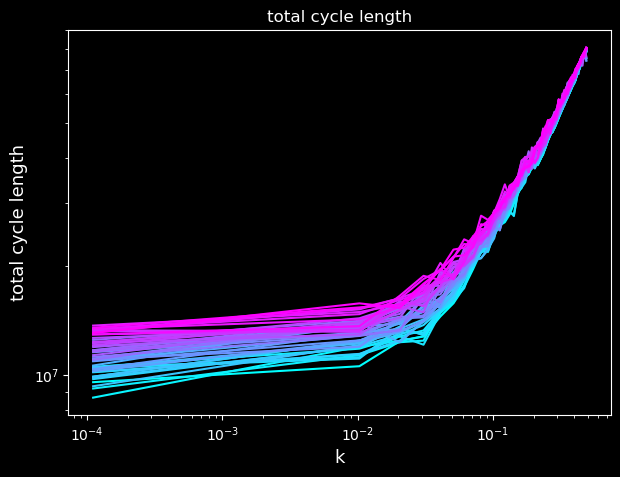

In [60]:
# as k increases how does cycle length increase for each p
colors = cm.cool(np.linspace(0, 1, len(cyclist)))
fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_nodes_list)):
    plt.plot(k_vals[:len(k_vals)-1], cyc_nodes_list[i], c = colors[i], label = cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-c')])
    axarr.set_title(str('total cycle length'))
    axarr.set_ylabel('total cycle length', size = '13')
    axarr.set_xlabel('k', size = '13')
axarr.set_xscale('log')
axarr.set_yscale('log')
#axarr.legend()
plt.show()

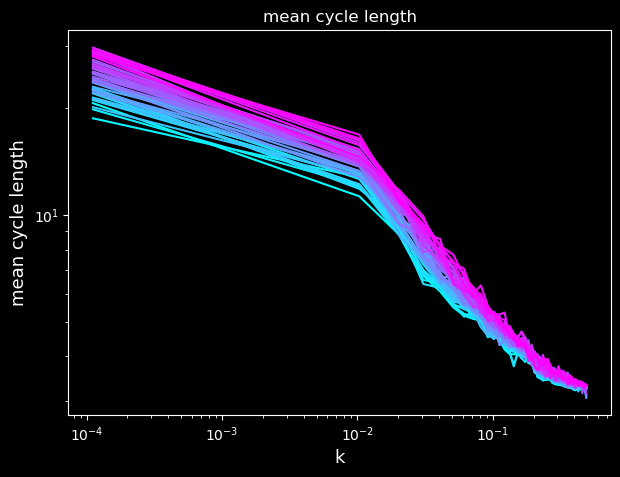

In [61]:
# as k increases how does mean cycle length change for each p

fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(mean_cyc_nodes_list)):
    plt.plot(k_vals[:len(k_vals)-1], mean_cyc_nodes_list[i], c = colors[i], label = cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-c')])
    axarr.set_title(str('mean cycle length'))
    axarr.set_ylabel('mean cycle length', size = '13')
    axarr.set_xlabel('k', size = '13')
#axarr.legend()
axarr.set_xscale('log')
axarr.set_yscale('log')
plt.show()

In [62]:
#Calculate cycle parameters 
cyc_n_list = list(range(len(np.load(cyclist[0],allow_pickle=True))))
cyc_nodes_list = list(range(len(np.load(cyclist[0],allow_pickle=True))))
mean_cyc_nodes_list = list(range(len(np.load(cyclist[0],allow_pickle=True))))

for i in range(len(np.load(cyclist[0],allow_pickle=True))):     
    cyc_n = np.zeros(len(cyclist))
    cyc_nodes = np.zeros(len(cyclist))
    mean_cyc_nodes = np.zeros(len(cyclist))
    for e in range(len(cyclist)):
        cyc_n[e] = np.load(cyclist[e], allow_pickle=True)[i][2]
        multi = np.multiply(np.load(cyclist[e], allow_pickle=True)[i][0][0],np.load(cyclist[e], allow_pickle=True)[i][0][1])
        cyc_nodes[e] =  np.sum(multi)
        mean_cyc_nodes[e] = (cyc_nodes[e]/cyc_n[e])
    cyc_n_list[i] = cyc_n
    cyc_nodes_list[i] = cyc_nodes
    mean_cyc_nodes_list[i] = mean_cyc_nodes

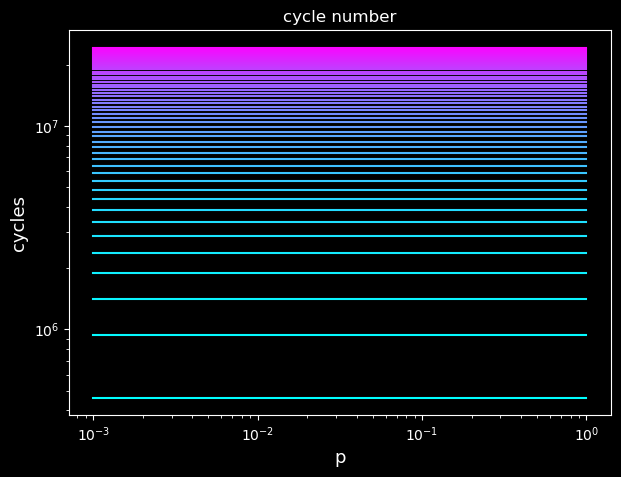

In [64]:
# as p increases how does cycles increase for each k

fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_n_list)):
    plt.plot(p_vals, cyc_n_list[i], c = colors[i], label = k_vals[i])
    axarr.set_title(str('cycle number'))
    axarr.set_ylabel('cycles', size = '13')
    axarr.set_xlabel('p', size = '13')
axarr.set_xscale('log')
axarr.set_yscale('log')
#axarr.legend()
plt.show()

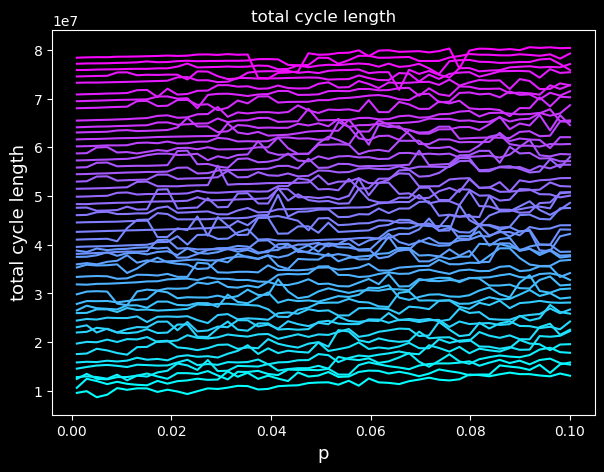

In [80]:
#as p increases how does total cycle length increase for each k

fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_nodes_list)):
    plt.plot(p_vals, cyc_nodes_list[i], c = colors[i], label = k_vals[i])
    axarr.set_title(str('total cycle length'))
    axarr.set_ylabel('total cycle length', size = '13')
    axarr.set_xlabel('p', size = '13')
#axarr.legend()
plt.show()

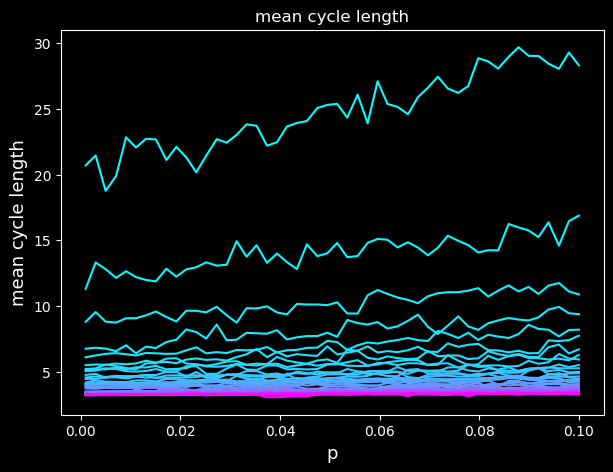

In [81]:
# as p increases how does mean cycle length increase
fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(mean_cyc_nodes_list)):
    plt.plot(p_vals, mean_cyc_nodes_list[i], c = colors[i], label = k_vals[i])
    axarr.set_title(str('mean cycle length'))
    axarr.set_ylabel('mean cycle length', size = '13')
    axarr.set_xlabel('p', size = '13')
#axarr.legend()
plt.show()

In [180]:
#Calculate cycle parameters 
cyc_n_list = list(range(len(cyclist)))
cyc_nodes_list = list(range(len(cyclist)))
mean_cyc_nodes_list = list(range(len(cyclist)))

for i in range(len(cyclist)):
    cyc_n = np.zeros(len(np.load(cyclist[i], allow_pickle=True)))
    cyc_nodes = np.zeros(len(np.load(cyclist[i], allow_pickle=True)))
    mean_cyc_nodes = np.zeros(len(np.load(cyclist[i], allow_pickle=True)))
    for e in range(len(np.load(cyclist[i], allow_pickle=True))):
        cyc_n[e] = np.load(cyclist[i], allow_pickle=True)[e][2]
        multi = np.multiply(np.load(cyclist[i], allow_pickle=True)[e][0][0],np.load(cyclist[i], allow_pickle=True)[e][0][1])
        cyc_nodes[e] =  np.sum(multi)
        mean_cyc_nodes[e] = (cyc_nodes[e]/cyc_n[e])
    cyc_n_list[i] = cyc_n
    cyc_nodes_list[i] = cyc_nodes
    mean_cyc_nodes_list[i] = mean_cyc_nodes

/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


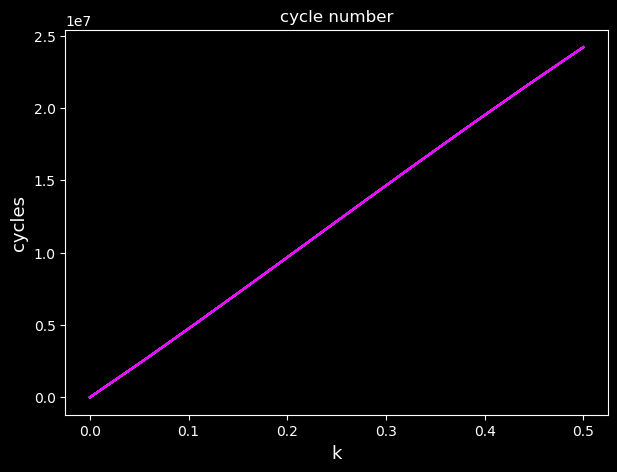

In [187]:
#K + P - LIN SCALE (high p)
#As k increases how do cycles increase for all p values
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

colors = cm.cool(np.linspace(0, 1, len(cyclist)))
fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_n_list)):
    plot1 = plt.plot(k_vals, cyc_n_list[i], c = colors[i],label = cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-c')])
    axarr.set_title(str('cycle number'))
    axarr.set_ylabel('cycles', size = '13')
    axarr.set_xlabel('k', size = '13')

#axarr.legend()
plt.show()

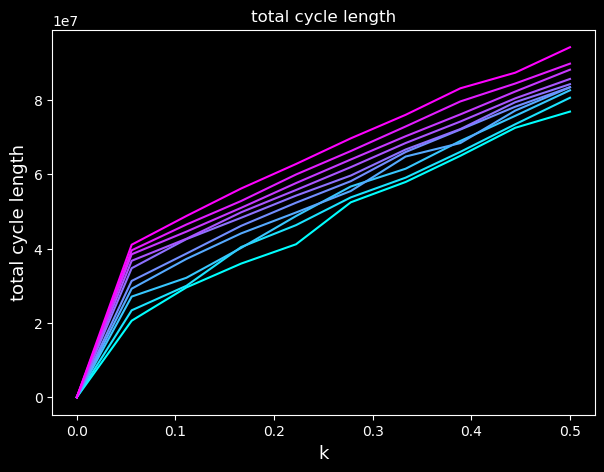

In [190]:
# as k increases how does cycle length increase for each p
colors = cm.cool(np.linspace(0, 1, len(cyclist)))
fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_nodes_list)):
    plt.plot(k_vals, cyc_nodes_list[i], c = colors[i], label = cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-c')])
    axarr.set_title(str('total cycle length'))
    axarr.set_ylabel('total cycle length', size = '13')
    axarr.set_xlabel('k', size = '13')
#axarr.legend()
plt.show()

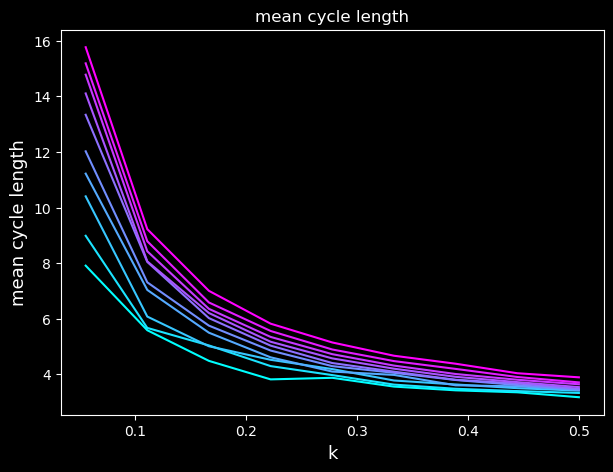

In [191]:
# as k increases how does mean cycle length change for each p

fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(mean_cyc_nodes_list)):
    plt.plot(k_vals, mean_cyc_nodes_list[i], c = colors[i], label = cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-c')])
    axarr.set_title(str('mean cycle length'))
    axarr.set_ylabel('mean cycle length', size = '13')
    axarr.set_xlabel('k', size = '13')
#axarr.legend()
plt.show()

In [192]:
#Calculate cycle parameters
cyc_n_list = list(range(len(np.load(cyclist[0],allow_pickle=True))))
cyc_nodes_list = list(range(len(np.load(cyclist[0],allow_pickle=True))))
mean_cyc_nodes_list = list(range(len(np.load(cyclist[0],allow_pickle=True))))

for i in range(len(np.load(cyclist[0],allow_pickle=True))):     
    cyc_n = np.zeros(len(cyclist))
    cyc_nodes = np.zeros(len(cyclist))
    mean_cyc_nodes = np.zeros(len(cyclist))
    for e in range(len(cyclist)):
        cyc_n[e] = np.load(cyclist[e], allow_pickle=True)[i][2]
        multi = np.multiply(np.load(cyclist[e], allow_pickle=True)[i][0][0],np.load(cyclist[e], allow_pickle=True)[i][0][1])
        cyc_nodes[e] =  np.sum(multi)
        mean_cyc_nodes[e] = (cyc_nodes[e]/cyc_n[e])
    cyc_n_list[i] = cyc_n
    cyc_nodes_list[i] = cyc_nodes
    mean_cyc_nodes_list[i] = mean_cyc_nodes

/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


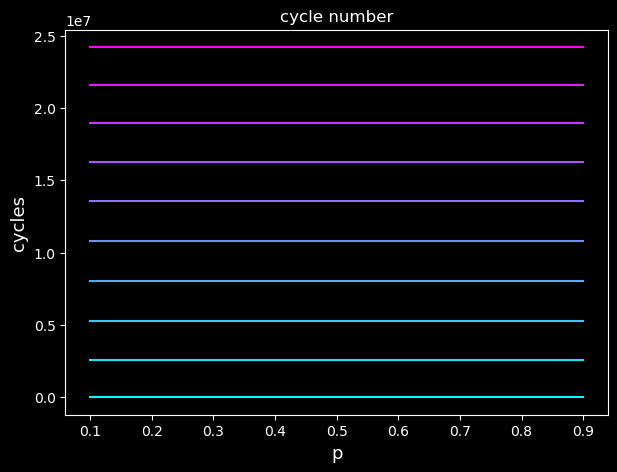

In [193]:
# as p increases how does cycles increase for each k

fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_n_list)):
    plt.plot(p_vals, cyc_n_list[i], c = colors[i], label = k_vals[i])
    axarr.set_title(str('cycle number'))
    axarr.set_ylabel('cycles', size = '13')
    axarr.set_xlabel('p', size = '13')
#axarr.legend()
plt.show()

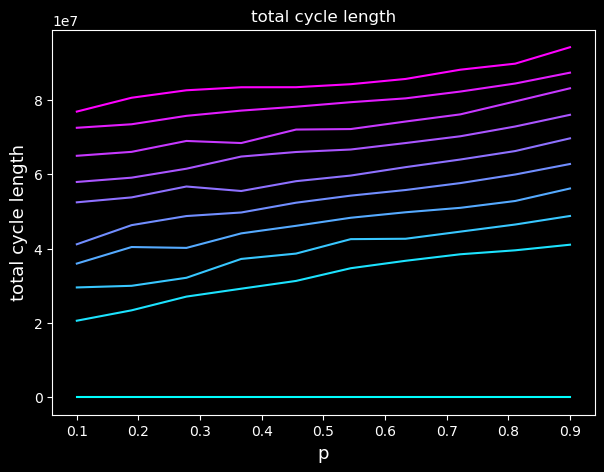

In [194]:
#as p increases how does total cycle length increase for each k

fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_nodes_list)):
    plt.plot(p_vals, cyc_nodes_list[i], c = colors[i], label = k_vals[i])
    axarr.set_title(str('total cycle length'))
    axarr.set_ylabel('total cycle length', size = '13')
    axarr.set_xlabel('p', size = '13')
#axarr.legend()
plt.show()

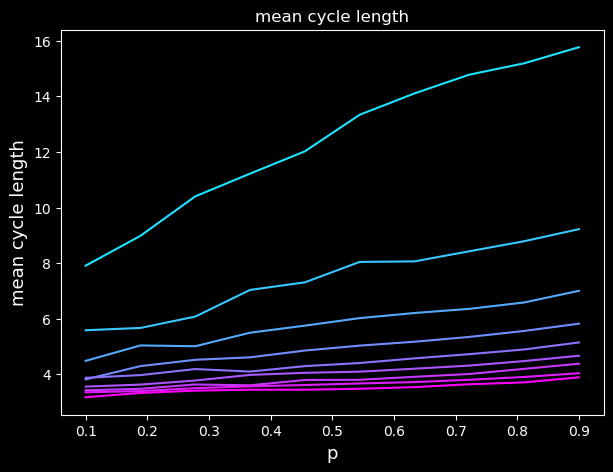

In [195]:
# as p increases how does mean cycle length increase

fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(mean_cyc_nodes_list)):
    plt.plot(p_vals, mean_cyc_nodes_list[i], c = colors[i], label = k_vals[i])
    axarr.set_title(str('mean cycle length'))
    axarr.set_ylabel('mean cycle length', size = '13')
    axarr.set_xlabel('p', size = '13')
#axarr.legend()
plt.show()